# Population Dynamics Model Selection

This notebook demonstrates the `compass` model comparison workflow on the example of four population dynamics models. These four models describe how the population size of two species (prey and predator) change over time. <br>
We will train `compass` on each of these four models and then use a synthetic observation time series to compare the models and select the best one.

The four ODEs, describing the population dynamics of prey (N) and predator (P), are:
1. **Lotka-Volterra:** The classic model with exponential prey growth and linear predator response. <br>
    $$ \begin{align*}
                dN/dt &= \alpha N-\beta NP \\
                dP/dt &= \delta NP-\gamma P
    \end{align*}$$

2. **Logistic Prey:** The prey population exhibits logistic growth with a carrying capacity $\delta'$, preventing unbounded growth and a fixed conversion efficiency $\epsilon=0.5$. The carrying capacity is defined as $\delta' = 1000*\delta$.
    $$\begin{align*}
        dN/dt &= \alpha N (1-N/\delta') - \beta NP \\
        dP/dt &= \epsilon \beta NP- \gamma P
    \end{align*}$$

3. **Satiated Predator:** The predator's consumption follows a Holling Type II functional response, where the predation rate per prey saturates as the prey population $N$ increases. The conversion efficiency is fixed to $\epsilon=0.5$.
    $$\begin{align*}
        \rm{consumption} &= \frac{\beta N}{1+\beta \delta N} \\
        dN/dt &= \alpha N-\rm{consumption}*P \\
        dP/dt &= \rm{consumption}*\epsilon P-\gamma P
    \end{align*}$$
    
4. **Rosenzweig-MacArthur:** A combination of the Logistic Prey and Satiated Predator models, incorporating a prey carrying capacity ($\delta' = 1000*\delta$), a fixed conversion efficiency $\epsilon=0.5$ and a fixed handling time ($h=0.1$).
    $$\begin{align*}
        \rm{consumption} &= \frac{\beta N}{1+\beta h N} \\
        dN/dt &= \alpha N (1-N/\delta') -\rm{consumption}*P \\
        dP/dt &= \rm{consumption}*\epsilon P-\gamma P
    \end{align*}$$


In [ ]:
from compass import ScoreBasedInferenceModel as SBIm
from compass import ModelTransfuser as MTf

import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Simple ODE solver using Euler method

def solve_ode(model_func, initial_state, params, t_max, dt):
    """
    Solves a system of ODEs using the Euler method.

    Args:
        model_func (function): The function defining the ODEs.
        initial_state (torch.Tensor): The starting values [N, P].
        params (dict): A dictionary of parameters for the model.
        t_max (int): The maximum simulation time.
        dt (float): The time step.

    Returns:
        (torch.Tensor, torch.Tensor): Tensors for time points and population history.
    """
    
    # Setup time steps and history arrays
    time_steps = torch.arange(0, t_max, dt)
    history = torch.zeros(initial_state.shape[0], len(time_steps), 2)
    history[:, 0, :] = initial_state
    
    # Current state starts at the initial state
    current_state = initial_state.clone()

    # Euler integration loop
    for i in range(1, len(time_steps)):
        # Get the derivatives from the model function
        derivatives = model_func(current_state, params)
        # Update the state using the Euler step
        current_state += derivatives * dt
        # Ensure populations don't go below zero
        current_state = torch.max(current_state, torch.tensor([0.0, 0.0]))
        history[:, i, :] = current_state
        
    return time_steps, history

In [ ]:
# Define the four population dynamics models
# Each model uses exactly four parameters: {alpha, beta, gamma, delta}

def lotka_volterra(state, params):
    """Model 1: Classic Lotka-Volterra dynamics."""
    N, P = state.T
    alpha, beta, gamma, delta = params.T

    dN_dt = alpha * N - beta * N * P
    dP_dt = delta * N * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

def logistic_prey(state, params):
    """Model 2: Prey with logistic growth."""
    
    N, P = state.T
    alpha, beta, gamma, delta = params.T
    delta_lp = delta * 1000  # Prey carrying capacity (logistic growth)
    cn_rate = 0.5  # Fixed conversion efficiency

    dN_dt = alpha * N * (1 - N / delta_lp) - beta * N * P
    dP_dt = cn_rate * beta * N * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

def satiated_predator(state, params):
    """Model 3: Predator with satiation (Holling Type II)."""
    N, P = state.T
    alpha, beta, gamma, delta = params.T
    cn_rate = 0.5 # Fixed conversion efficiency

    consumption = (beta * N) / (1 + beta * delta * N)
    dN_dt = alpha * N - consumption * P
    dP_dt = cn_rate * consumption * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

def rosenzweig_macarthur(state, params):
    """Model 4: Both logistic prey and satiated predator."""
    N, P = state.T
    alpha, beta, gamma, delta = params.T
    delta_rm = delta * 1000  # 
    cn_rate = 0.5 # Fixed conversion efficiency
    h_rate = 0.1 # Fixed handling time

    consumption = (beta * N) / (1 + beta * h_rate * N)
    dN_dt = alpha * N * (1 - N / delta_rm) - consumption * P
    dP_dt = cn_rate * consumption * P - gamma * P
    return torch.stack([dN_dt, dP_dt]).T

## Create Mock Observation

In [ ]:
# Initial conditions [N0, P0]
initial_state = torch.tensor([[30.0, 1.0]])
# Mock observation parameters (log-space) {alpha, beta, gamma, delta}
mock_params = torch.tensor([[-0.1, -3.0, -0.1, -3.0]])

# Simulation time
t_max = 20
dt = 0.01

# List of models to run
model_names = ["Logistic Prey", "Satiated Predator", "Rosenzweig-MacArthur", "Lotka-Volterra"]
models = {
    "Lotka-Volterra": lotka_volterra,
    "Logistic Prey": logistic_prey,
    "Satiated Predator": satiated_predator,
    "Rosenzweig-MacArthur": rosenzweig_macarthur
}


# Generate mock observation data using the Lotka-Volterra model
mock_func = models["Lotka-Volterra"]
time, history = solve_ode(mock_func, initial_state, torch.exp(mock_params), t_max, dt)

# Sample data every 1 time unit and scale down for normalization
test_data = history[:, time % 1 == 0].flatten(1)/100

## Load pretrained models

The four models have been pretrained using `compass` and are available under `tutorials/data/population_dynamics/`. <br>
Each model has been trained till convergence with $5*10^5$ data points and validated on $5*10^4$ data points, each with a length of 20 time units and sampled every full time unit (i.e., 20 time points for each predator and prey).
The parameters ${\alpha, \beta, \gamma, \delta}$ for the training data were randomly sampled from a log-normal distribution.
\begin{align*}
    \log(\alpha) &\sim \rm{LogNormal}(-0.125,0.5) \\
    \log(\beta) &\sim \rm{LogNormal}(-3,0.5) \\
    \log(\gamma) &\sim \rm{LogNormal}(-0.125,0.5) \\
    \log(\delta) &\sim \rm{LogNormal}(-3,0.5)
\end{align*}
This follows the common sbi benchmark setup for Lotka-Volterra models proposed by [Lueckmann et al. (2021)](https://arxiv.org/abs/2101.04653). <br> <br>

We first have to initialize the `ModelTransfuser` (`MTf`) class and then load the pretrained `ScoreBasedInferenceModel`(`SBIm`) and add it to the `MTf` using the `add_model` method. <br>


In [ ]:
mtf = MTf(path="data/population_dynamics")

In [ ]:
# Load the pretrained models
for model_name, _ in models.items():
    sbim = SBIm.load(f"data/population_dynamics/{model_name}.pt", device="cuda")
    mtf.add_model(model_name, sbim)

Model Lotka-Volterra added to transfuser.
Model Logistic Prey added to transfuser.
Model Satiated Predator added to transfuser.
Model Rosenzweig-MacArthur added to transfuser.


## Run Comparison
We can now run the model comparison on the mock observations using the `compare` method of the `MTf` class. <br>

In [13]:
mtf.compare(x=test_data, device="cuda", timesteps=50, method="dpm", order=2)

Probabilities of the models after 1 observations:
Lotka-Volterra      : 100.00 %
Logistic Prey       :   0.00 %
Satiated Predator   :   0.00 %
Rosenzweig-MacArthur:   0.00 %

Model Lotka-Volterra fits the data best with a relative support of 100.0% among the considered models.


The diffusion model ran for just $50$ denoising steps, which is sufficient for this low-dimensional problem to identify the correct model. <br>

## Plot the results
We can now visualize the results of the model comparison, by performing a posterior predictive check using the Maximum A Posteriori (MAP) parameters for each model.
We run the ODE solver with the MAP parameters and plot the resulting population dynamics for prey and predator.
The true model (Lotka-Volterra) fits the mock observation data best, while the other models deviate more strongly from the data.

In [ ]:
def plot_results_test(names):
    initial_state = torch.tensor([[30.0,1.0]])

    # Simulation time
    t_max = 20
    dt = 0.01

    fig, axs = plt.subplots(2,1, sharex=True, figsize=(10,5), constrained_layout=True, dpi=500)

    time = torch.arange(0,20)

    colours = ['blue', 'orange', 'green', 'red']
    for i, model_name in enumerate(names):
        params = torch.exp(torch.tensor(mtf.stats[model_name]["MAP"][0,0]))
        time_best, history_best = solve_ode(models[model_name], initial_state, params, t_max, dt)
        sns.lineplot(x=time_best, y=history_best[0, :, 0], color=colours[i], label=model_name, ax=axs[0])
        sns.lineplot(x=time_best, y=history_best[0, :, 1], color=colours[i], label=model_name, ax=axs[1])


    axs[0].scatter(x=time, y=test_data[0,::2]*100,
                     color='k', s=10, zorder=10)
    axs[1].scatter(x=time, y=test_data[0,1::2]*100,
                     color='k', s=10, zorder=10)

    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(names)+1, frameon=False, fontsize=12)
    plt.xlabel('Time', fontsize=15)
    plt.xlim(0,20)
    axs[0].set_ylabel('Prey Population', fontsize=15)
    axs[1].set_ylabel('Predator Population', fontsize=15)
    plt.tight_layout()
    axs[1].legend().remove()
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.show()

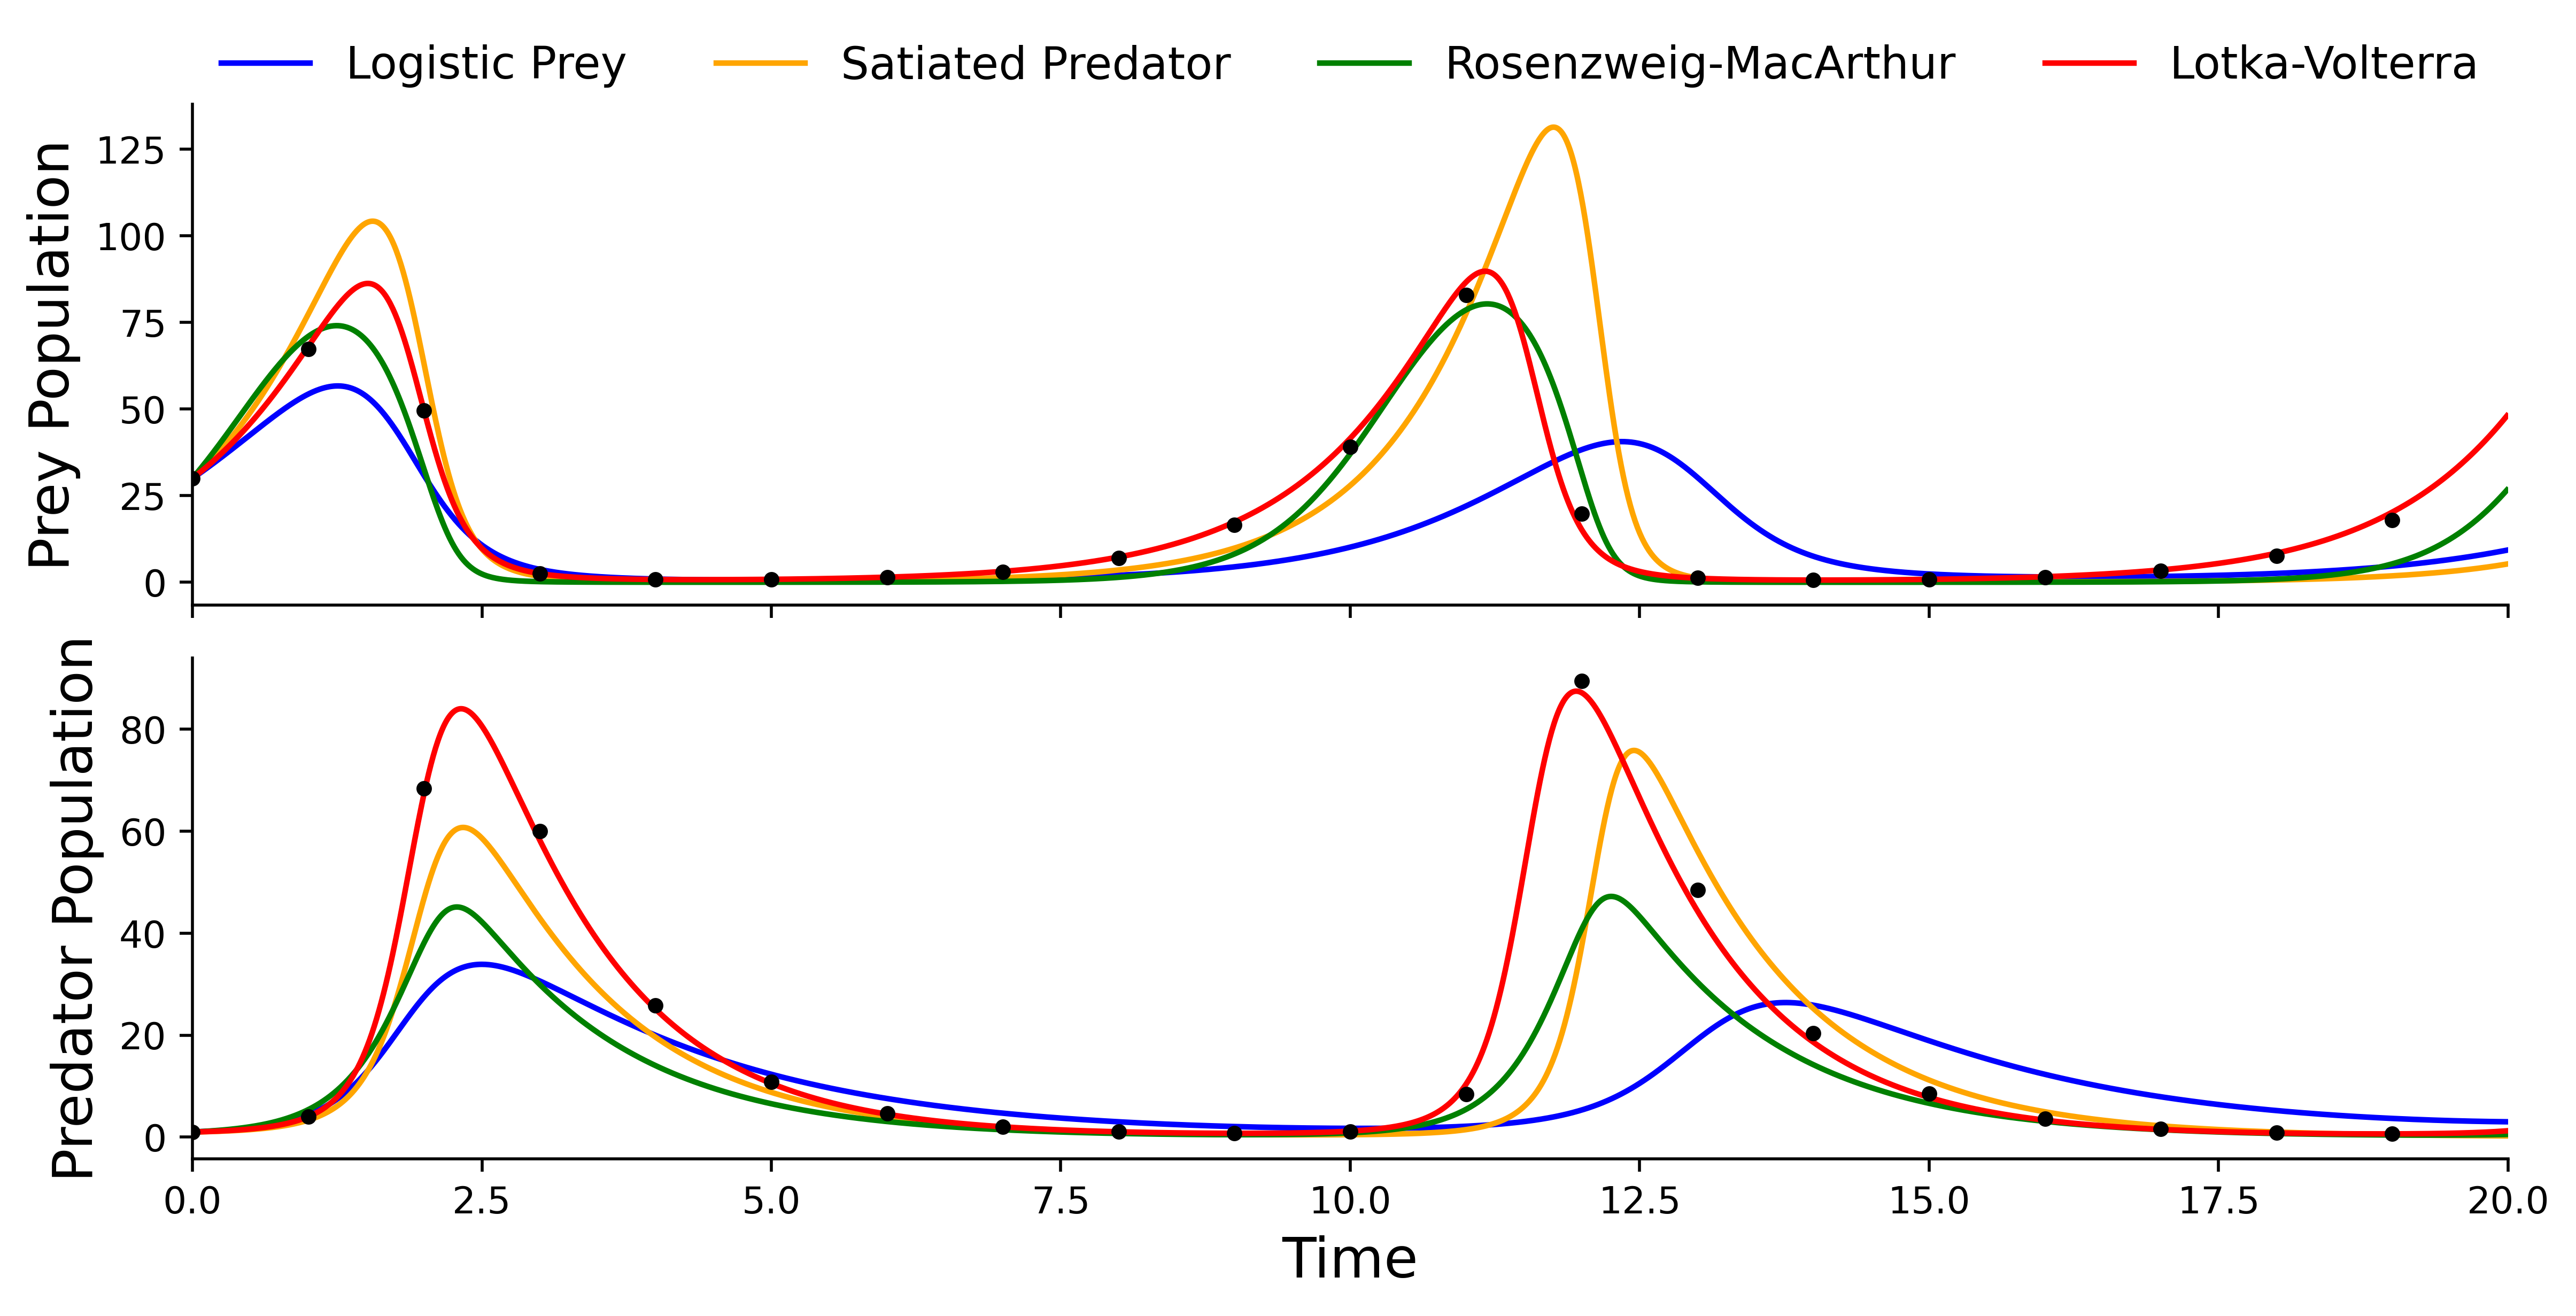

In [ ]:
plot_results_test(model_names)

## Model Selection
To understand how `compass` performs the model comparison, we can look at the maximised likelihood function for each model.
After inferring the modelling the posterior distribution and obtaining the MAP parameters, `compass` models the maximised likelihood distribution.
We can visualize this distribution (see below). <br> <br>
In order to select the best model, we evaluate this distribution at the point of the observations and select the model with the highest likelihood. <br>
The plot below shows the maximised likelihood distributions and the observed data point as a vertical dashed line. <br> 
We just visualize the first $10$ timesteps of the time series to increase visibility, but the model comparison was performed on the full time series of $20$ timesteps. <br>

In [ ]:
def plot_res(model_names):
    samples = {}
    
    for model_name in model_names:
        sbim = SBIm.load(f"data/population_dynamics/{model_name}.pt", device="cuda")

        theta_hat = torch.tensor(mtf.stats[model_name]["MAP"][0,0]).float()
        err = torch.tensor(mtf.stats[model_name]["MAP"][0,1]).float()

        samples[model_name] = sbim.sample(theta=theta_hat, err=err, device="cuda", timesteps=50, method="dpm", order=2)

    # plot histograms of samples and true values
    fig, ax = plt.subplots(2, 10, figsize=(14, 2), sharey=True, dpi=500)
    sns.set_style("white")
    fig.text(0.1, 0.5, 'Population Densities', va='center', rotation='vertical', fontsize=12)

    colours = ['blue', 'orange', 'green', 'red']

    for i in range(20):
        row, col = i % 2, i // 2
        for j, model_name in enumerate(model_names):
            sns.kdeplot(samples[model_name][0, :, i].cpu().numpy()*100, fill=True, alpha=0.3, ax=ax[row, col], color=colours[j])

        ax[row, col].axvline(x=test_data[0, i]*100, color='k', linestyle=':', label='True Value')
        if row == 0:
            ax[row, col].set_title(rf'$T_{{{i/2.0:.0f}}}$')
            if i == 0:
                ax[row, col].set_ylabel("N", labelpad=-8)
        if row == 1 and col == 0:   
            ax[row, col].set_ylabel("P", labelpad=-8)
        ax[row, col].set_xticklabels([])
        ax[row, col].set_yticklabels([])
        ax[row, col].tick_params(left=False, bottom=False)

        for spine in ax[row, col].spines.values():
            spine.set_visible(False)

    fig.legend(model_names + ['True Value'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(model_names)+1, frameon=False)
    fig.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

100%|████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


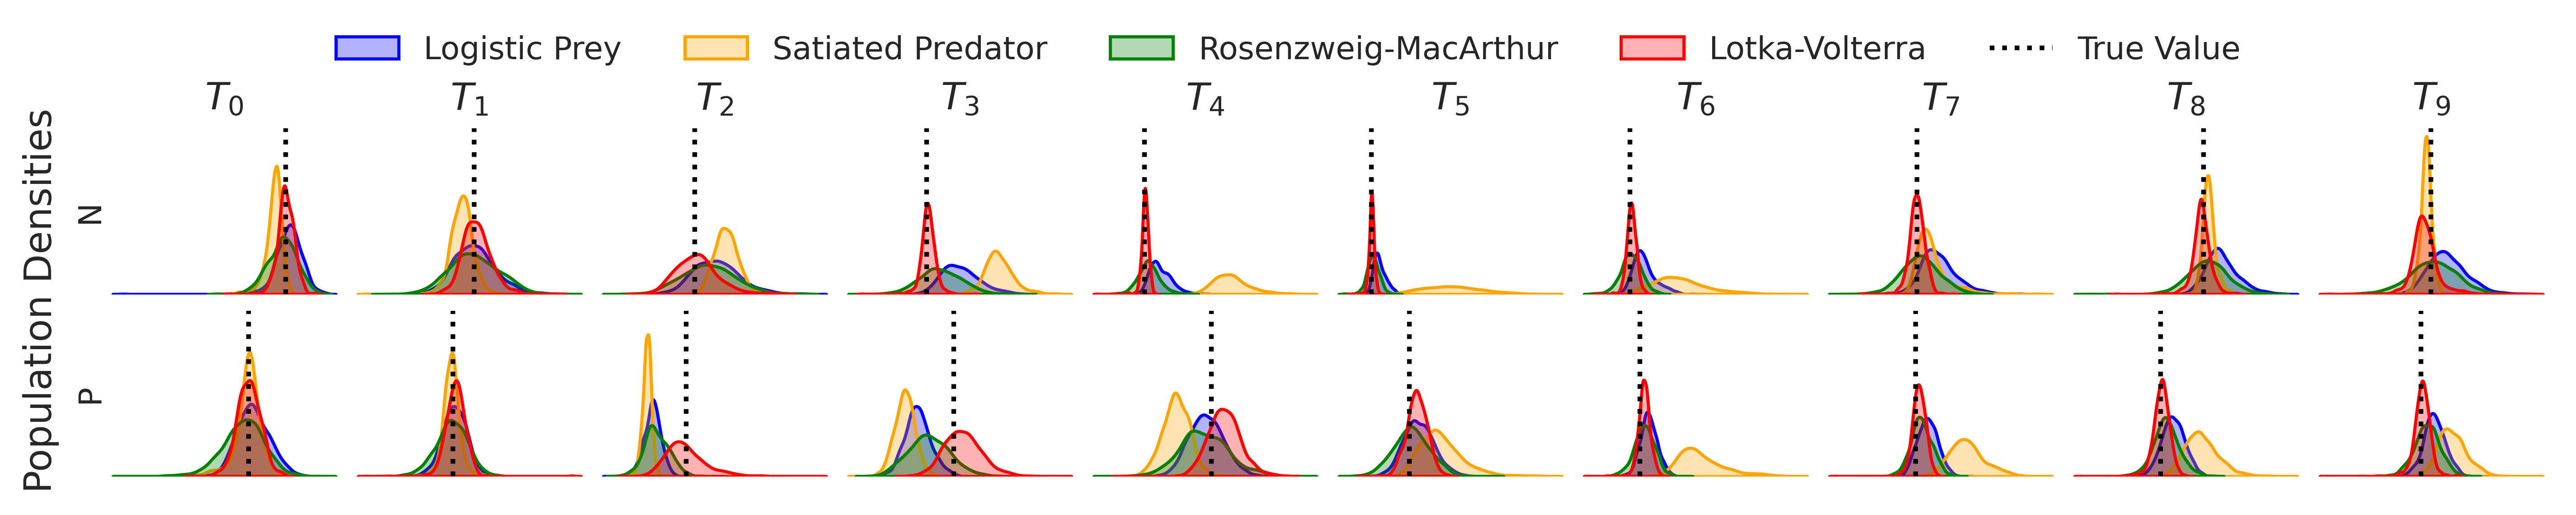

In [ ]:
plot_res(model_names)